## Abstract

- Utiliser un réseau RNN pour prédire les quelques n+ièmes  pas des cours de bourses de sociétés du SP500.
- Qualifier et quantifier les écarts.
- En déduire quels sont les sociétés dont les cours sont les plus "prévisibles" ou à défauts ceux dont les cours sont le moins erratiques.

## Bibliothèques

In [1]:
# Générique data project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

# Pour la manipulation de fichiers
import os
import glob
from pathlib import Path

# Pour RNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, RNN,GRUCell,InputLayer,Embedding,Dropout


# MISC
import warnings
warnings.filterwarnings("ignore")
import swifter
import random

## Set up

In [2]:
df = pd.read_csv('sp500_stocks.csv')
df = df.dropna()


## Paramètres

In [3]:
sequence_len = 100
predict_len  = 5
train_prop    = 0.8
batch_size    = 32
epok        = 20
cwd = os.getcwd()
path = cwd

## Fonction de généralisation

On applique la démarche pour chaque cours et on stocke les valeurs dans une dataframe

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [5]:

def evalue(x):


    DF = df[df['Symbol']==x]
    dataset = np.array(DF.Close)
    k = int(len(dataset)*train_prop)
    x_train = dataset[:k]
    x_test  = dataset[k:]
    mean = x_train.mean()
    std  = x_train.std()
    x_train = (x_train - mean) / std
    x_test  = (x_test  - mean) / std
    x_train = x_train.reshape(-1,1)
    x_test = x_test.reshape(-1,1)
    train_generator = TimeseriesGenerator(x_train,x_train ,length=sequence_len,  batch_size=batch_size)
    test_generator  = TimeseriesGenerator(x_test,x_test , length=sequence_len,  batch_size=batch_size)
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.GRU(64, return_sequences=False,input_shape=(sequence_len,1),activation='relu') )
    model.add(Dropout(0.3))
    

    
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics   = ['mae'] )
    bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path, verbose=0, save_best_only=True)

    training_history=model.fit(train_generator,
                  epochs  = epok, 
                  validation_data = test_generator,verbose = 0,
                          callbacks = [bestmodel_callback])
    
    loaded_model =  tf.keras.models.load_model(cwd)




    loss,mae =loaded_model.evaluate(test_generator)
    return x_test,mae,loaded_model

In [6]:
def plot_last_seq(x_test,model):

    # On sélectionne la dernière séquence
    sequence = x_test[-sequence_len:-1]

    # On définit la séquence réelle à observer
    sequence_true = x_test[-sequence_len:]

    # On prédit la valeur suivante de sequence
    prediction = model.predict( np.array([sequence]))

    # On affiche
    plt.plot(np.concatenate([sequence,prediction]),label = 'Predit')
    plt.plot(sequence_true,label = 'Vrai')

    plt.legend()

In [7]:
def predicat(x_test,model):

    Predicat =[]
    step = 4
    iteration = list(reversed([i for i in range(step)]))

    for i in iteration:
        sequence = x_test[-sequence_len-i:-i-1]
   
        prediction = model.predict( np.array([sequence]))
        Predicat.append(prediction)
    
    vue = np.concatenate([Predicat[0],Predicat[1],Predicat[2],Predicat[3]])

    plt.plot(np.concatenate([x_test[-sequence_len:-step],vue]),label = 'Prédit')
    plt.plot(x_test[-sequence_len:],label = 'vrai')

    plt.legend() 

In [8]:
def boule_cristal(x_test,model):

    Predicat =[]
    step = 4
    iteration = list(reversed([i for i in range(step)]))
    x_dessein = x_test.copy()

    for i in iteration:
        sequence = x_dessein[-sequence_len:]
   
        prediction = model.predict( np.array([sequence]))
        Predicat.append(prediction)
        x_dessein= np.concatenate([x_dessein,Predicat[-1]])
    
    vue = np.concatenate([Predicat[0],Predicat[1],Predicat[2],Predicat[3]])

    plt.plot(np.concatenate([x_test[-sequence_len:],vue]),label = 'Prédit')
    plt.plot(x_test[-sequence_len:],label = 'vrai')

    plt.legend() 

## Titre à suivre

In [9]:
bourse =['DXC','VTRS','NWL','BKR','MRO','INCY','WMB']
a = len(bourse)

INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
17/17 [==============================] - 0s 9ms/step - loss: 0.0017 - mae: 0.0295
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
17/17 [=============================

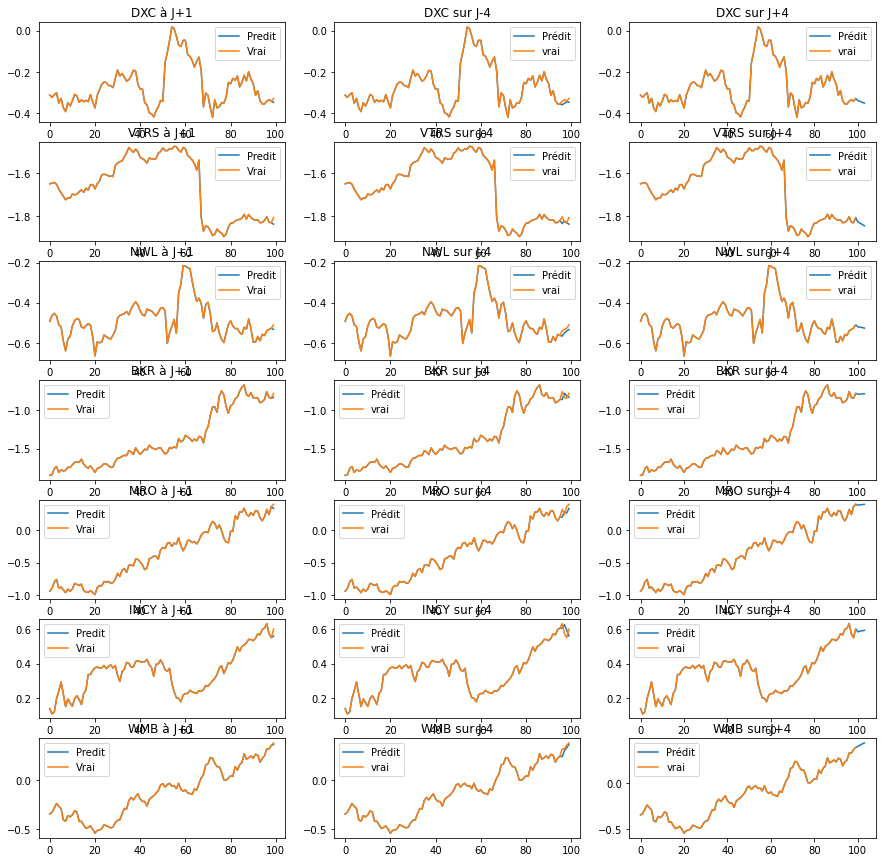

In [10]:
plt.figure(figsize=(15,15))

j = 1

for titre in bourse:
    x_test,mae,model = evalue(titre)
    plt.subplot(a,3,j)
    plot_last_seq(x_test,model)
    plt.title(f'{titre} à J+1')
    j +=1
    plt.subplot(a,3,j)
    predicat(x_test,model)
    plt.title(f'{titre} sur J-4')
    j+=1
    plt.subplot(a,3,j)
    boule_cristal(x_test,model)
    plt.title(f'{titre} sur J+4')
    j+=1
    
plt.show()

INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
17/17 [==============================] - 0s 10ms/step - loss: 0.0018 - mae: 0.0310


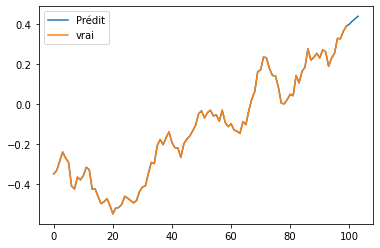

In [12]:
evalue('DXC')
boule_cristal(x_test,model)
plt.show()